### Part 1 - Sentiment Analysis on Yelp Dataset

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# load yelp dataset here
dataset = load_dataset("yelp_polarity")

# preprocess the data
def preprocess(examples):
    return {"text": examples["text"], "label": examples["label"]}

dataset = dataset.map(preprocess, remove_columns=dataset["train"].column_names)

# split dataset into train and test using their column names
train_val_data = dataset["train"]
test_data = dataset["test"]

train_val_split = train_val_data.train_test_split(test_size=0.1, seed=42)
train_data = train_val_split['train']
val_data = train_val_split['test']

# make vocabulary
vocab = set()
for text in train_data["text"]:
    vocab.update(text.split())
vocab = list(vocab)
word_to_idx = {word: idx for idx, word in enumerate(vocab)}

# convert text to indices
def text_to_indices(text):
    return [word_to_idx.get(word, len(vocab)) for word in text.split()]

# my model
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embed_dim, padding_idx=vocab_size)
        self.fc = nn.Linear(embed_dim, 1)
    
    def forward(self, x):
        embedded = self.embedding(x)
        pooled = embedded.mean(dim=1)
        return self.fc(pooled).squeeze()

# my hyperparameters
embed_dim = 10
batch_size = 64
num_epochs = 5
learning_rate = 0.001

def create_dataset(data):
    texts = [torch.tensor(text_to_indices(text)) for text in data["text"]]
    labels = torch.tensor(data["label"])
    return TensorDataset(nn.utils.rnn.pad_sequence(texts, batch_first=True), labels)

train_dataset = create_dataset(train_data)
val_dataset = create_dataset(val_data)
test_dataset = create_dataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model = SentimentModel(len(vocab), embed_dim)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    # train
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.float().to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # validate
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            val_loss += loss.item()
            predicted = (outputs > 0).int()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss/len(train_loader):.4f}")
    print(f"Val Loss: {val_loss/len(val_loader):.4f}")
    print(f"Val Accuracy: {100*correct/total:.2f}%")

# evaluate
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = (outputs > 0).int()
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100*test_correct/test_total:.2f}%")

Epoch 1/5: 100%|██████████| 7875/7875 [05:34<00:00, 23.58it/s] 


Epoch 1/5
Train Loss: 0.5891
Val Loss: 0.4534
Val Accuracy: 84.34%


Epoch 2/5: 100%|██████████| 7875/7875 [01:02<00:00, 126.30it/s]


Epoch 2/5
Train Loss: 0.3760
Val Loss: 0.3132
Val Accuracy: 89.64%


Epoch 3/5: 100%|██████████| 7875/7875 [01:01<00:00, 127.63it/s]


Epoch 3/5
Train Loss: 0.2828
Val Loss: 0.2592
Val Accuracy: 90.78%


Epoch 4/5: 100%|██████████| 7875/7875 [01:01<00:00, 127.30it/s]


Epoch 4/5
Train Loss: 0.2412
Val Loss: 0.2327
Val Accuracy: 91.68%


Epoch 5/5: 100%|██████████| 7875/7875 [01:02<00:00, 126.87it/s]


Epoch 5/5
Train Loss: 0.2177
Val Loss: 0.2186
Val Accuracy: 92.11%
Test Accuracy: 92.34%


### Part 2 - Results Analysis

#### Sparsity Histogram

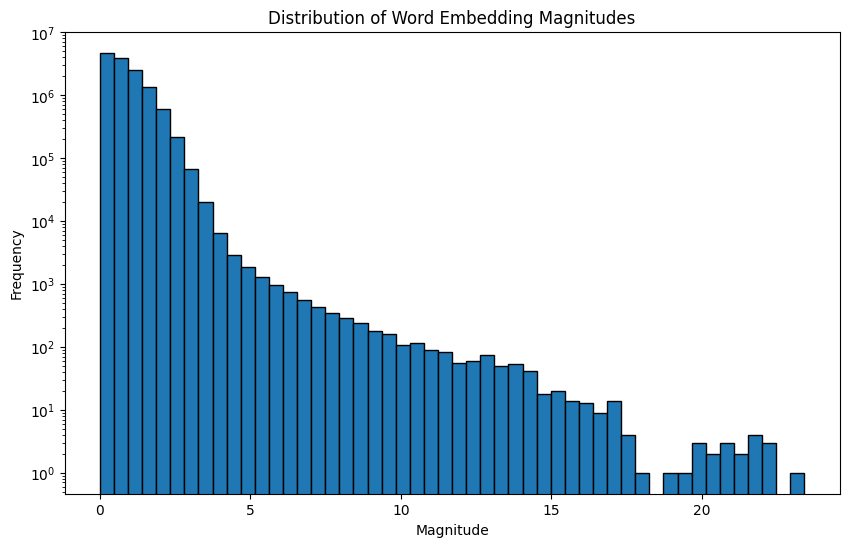

In [19]:
import numpy as np
import matplotlib.pyplot as plt

word_embeddings = model.embedding.weight.detach().cpu().numpy()

magnitudes = np.abs(word_embeddings).flatten()

# histogram
plt.figure(figsize=(10, 6))
plt.hist(magnitudes, bins=50, edgecolor='black')
plt.title('Distribution of Word Embedding Magnitudes')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.yscale('log') 
plt.show()

#### Words with Large Components

In [16]:
def get_top_words_for_component(word_embeddings, vocab, component, top_n=10):
    component_values = word_embeddings[:, component]
    top_indices = np.argsort(np.abs(component_values))[-top_n:][::-1]
    return [(vocab[i], component_values[i]) for i in top_indices]

vocab = list(word_to_idx.keys())

# first 5 components
for component in range(5): 
    top_words = get_top_words_for_component(word_embeddings, vocab, component)
    print(f"\nTop words for component {component}:")
    for word, value in top_words:
        print(f"{word}: {value:.4f}")


Top words for component 0:
Great: -22.0935
worst: 20.1121
mediocre: 17.6123
Worst: 17.2407
delicious.: -16.9705
rude: 16.8372
amazing.: -15.3631
Love: -15.3539
terrible.: 14.8212
Terrible: 14.7144

Top words for component 1:
Great: 23.4056
worst: -19.2817
bland: -17.1735
Love: 16.6226
mediocre: -16.4949
Worst: -15.7591
delicious.: 15.4944
rude: -15.3140
waste: -15.1315
:): 15.0627

Top words for component 2:
Great: 21.6424
worst: -21.5720
bland: -17.3457
delicious.: 17.2520
mediocre: -16.8846
Worst: -16.3972
Love: 16.3117
Horrible: -15.4485
horrible: -15.3773
Excellent: 15.2962

Top words for component 3:
worst: 20.7080
Great: -18.7885
Love: -17.2007
rude: 17.0670
Worst: 16.4599
mediocre: 16.1681
terrible: 15.2863
amazing.: -15.2655
terrible.: 14.9853
Horrible: 14.9671

Top words for component 4:
worst: 22.4271
Great: -21.6422
Love: -17.6269
Worst: 17.0314
mediocre: 16.9868
delicious.: -16.9834
amazing.: -16.8211
rude: 16.1808
terrible.: 16.0335
:): -15.9567


#### Analyze Weight Vector

In [17]:
# Extract the weight vector
w = model.fc.weight.detach().cpu().numpy().flatten()

# Check sparsity of w
w_sparsity = np.mean(np.abs(w) < 1e-3)
print(f"Sparsity of w: {w_sparsity:.2%}")

# Find most positive and negative components
most_positive = np.argmax(w)
most_negative = np.argmin(w)

print(f"Most positive component: {most_positive}")
print(f"Most negative component: {most_negative}")

# Get top words for these components
print("\nTop words for most positive component:")
top_positive = get_top_words_for_component(word_embeddings, vocab, most_positive)
for word, value in top_positive:
    print(f"{word}: {value:.4f}")

print("\nTop words for most negative component:")
top_negative = get_top_words_for_component(word_embeddings, vocab, most_negative)
for word, value in top_negative:
    print(f"{word}: {value:.4f}")

Sparsity of w: 0.00%
Most positive component: 2
Most negative component: 6

Top words for most positive component:
Great: 21.6424
worst: -21.5720
bland: -17.3457
delicious.: 17.2520
mediocre: -16.8846
Worst: -16.3972
Love: 16.3117
Horrible: -15.4485
horrible: -15.3773
Excellent: 15.2962

Top words for most negative component:
worst: 21.0932
Great: -20.2147
delicious.: -17.3148
Worst: 17.0650
Love: -17.0421
mediocre: 16.3206
bland: 16.0012
delicious!: -15.7475
rude: 15.7416
horrible.: 15.6185
